In [16]:
%pylab inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import numpy as np
import scipy.io as spio
import os
from os.path import dirname, join as pjoin
from numpy import array
import random
from matplotlib import pyplot as plt
from IPython.display import clear_output
from collections import Counter
import seaborn as sns
import glob
import matplotlib.ticker as ticker
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['mat', 'i0', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
ls

gdrive/  sample_data/


In [3]:
cd gdrive/"My Drive"/"NDT Phase II"/

/content/gdrive/My Drive/NDT Phase II


In [0]:
mat_path = pjoin('Dataset','data.mat')
mat = spio.loadmat(mat_path)
cell_data = mat['data']

0.9030582275390625 0.15069004374986072


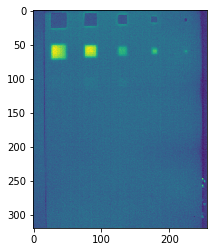

In [57]:
dataT = cell_data.T
#access image by index
i0 = dataT[10]
print(np.mean(i0),np.std(i0))
plt.imshow(i0)

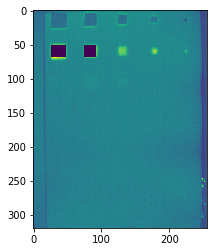

In [55]:

# for ii in range(51,69):
#   for jj in range(26,48):
#     i0[ii][jj] = 0
# plt.imshow(i0)

In [0]:
class Args:
    def __init__(self):
        self.cuda = True
        self.no_cuda = False
        self.seed = 1
        self.epochs = 10
        self.lr = 0.0001
args = Args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

In [0]:
def transform_fn(data):
  data = data.astype(np.float32)
  data = torch.from_numpy(data)
  return data

In [0]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()     
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=1),
            nn.ReLU(True),
            nn.Conv2d(4,16,kernel_size=1),
            nn.ReLU(True),
            nn.Conv2d(16,32,kernel_size=1),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32,16,kernel_size=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16,4,kernel_size=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(4,1,kernel_size=1),
            nn.ReLU(True),
            nn.Sigmoid())
    def forward(self,x):
        h,w = x.size()
        x = x.view(1,1,h,w)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [0]:
model = Autoencoder()
if args.cuda: 
     model.cuda()
distance = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

epoch [1/10], loss:0.1958


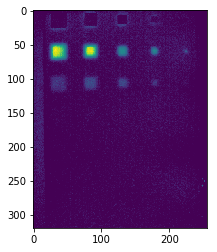

699.3473819821478
1899.4346021499764
epoch [2/10], loss:0.2139


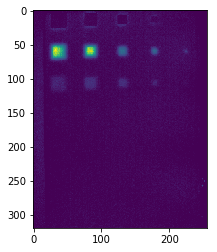

563.9322395782586
1531.6252499924294


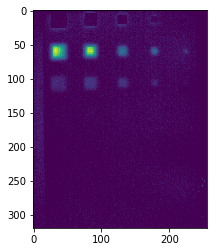

436.44303824696016
1185.3667166092982
epoch [4/10], loss:1.0292


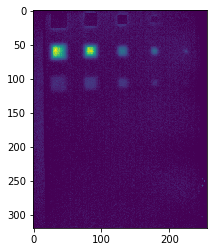

326.178022078697
885.8882947223761
epoch [5/10], loss:0.1056


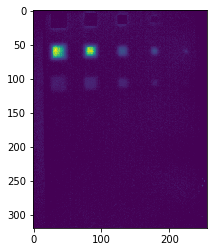

322.5255023089477
875.9634651239273
epoch [6/10], loss:0.0125


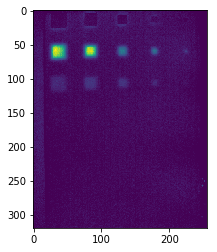

121.30329161158095
329.42793343048044
epoch [7/10], loss:0.0989


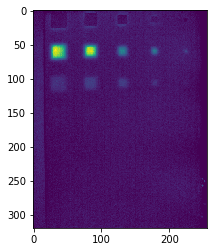

84.87637735371844
230.49416220121668
epoch [8/10], loss:0.1225


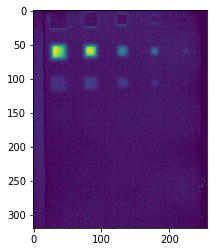

66.74351911880115
181.2454187532246
epoch [9/10], loss:0.0926


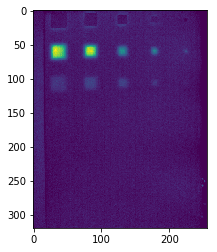

48.81162215059588
132.54364199185164


KeyboardInterrupt: ignored

In [178]:
l = 40
val = []
for epoch in range(args.epochs):
    model.train()
    c = []
    for i in range(250):
        c.append(i)
    random.shuffle(c)
    for i in range(1,250):
        data = transform_fn(dataT[c[i]-1])
        data = torch.FloatTensor(data)
        if args.cuda:
                data = data.cuda()
        data = Variable(data)
        optimizer.zero_grad()
        output = model(data) 
        loss = distance(output, data[c[i]-1])
        if(l>loss.item()):
          l = loss.item()
          img = output.cpu()
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, args.epochs, loss.item()))
    img2= img.detach().numpy()
    img2= np.reshape(img2,(320,256))
    plt.imshow(img2)
    plt.show()
    SNR(img2)
    val.append(img2)
    #img = output.cpu()
img = img.detach().numpy()
img = np.reshape(img,(320,256))
plt.imshow(img)

In [0]:
np.save("250.npy",img)

In [0]:
# i1 = i0[:]
# for i in range(72,94):
#   for j in range(102,124):
#     i1[i][j] = 0
# plt.imshow(i0)

In [0]:
def SNR_250(dataT):
  variance = []
  defected_sum = []
  non_defected_sum = []
  for i in range(250):
    values = []
    p = 1
    d_sum = 0
    non_sum = 0
    for j in range(50,72):
      for k in range(26,48):
        d = dataT[i]
        d_sum = d_sum + d[j][k]
    defected_sum.append(d_sum)
    for j in range(72,94):
      for k in range(102,124):
        d = dataT[i]
        values.append(d[j][k])
        non_sum = non_sum + d[j][k]
    non_defected_sum.append(non_sum)
    variance.append(var(values))
  signal = (list(set(defected_sum) - set(non_defected_sum)))
  noise = sqrt(variance)
  SNR = signal/(noise*484)
  return max(SNR)

In [0]:
def SNR(dataT):
  variance = []
  defected_sum = []
  non_defected_sum = []
  values = []
  d_sum = 0
  non_sum = 0
  d1 = [50,72,51,69]
  d2 = [26,48,75,93]
  for j in range(72,94):
      for k in range(102,124):
        d = dataT
        values.append(d[j][k])
        non_sum = non_sum + d[j][k]
  non_defected_sum.append(non_sum)
  variance.append(var(values))
  for p in range(0,2):
    for j in range(d1[p*2],d1[p*2+1]):
        for k in range(d2[p*2],d2[p*2]+1):
          d = dataT
          d_sum = d_sum + d[j][k]
    defected_sum.append(d_sum)
    signal = (list(set(defected_sum) - set(non_defected_sum)))
    noise = sqrt(variance)
    SNR = signal/(noise*((d1[p*2+1]-d1[p*2])**2))
    if(len(SNR)==0):
      return 0
    else:
      print(max(SNR))
  return max(SNR)

In [0]:
SNR(img),SNR_250(dataT)

(196.38725104916816, 94.80898697122812)

inf
inf
inf


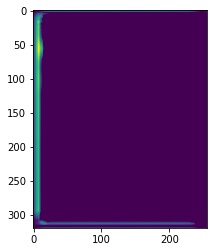

inf
inf
inf


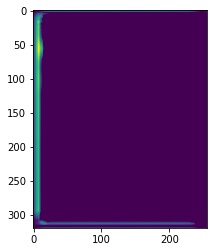

inf
inf
inf


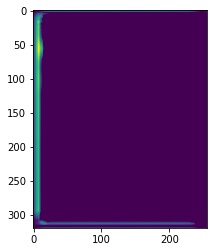

inf
inf
inf


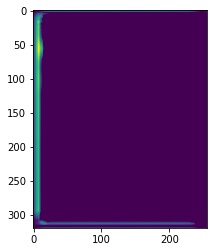

inf
inf
inf


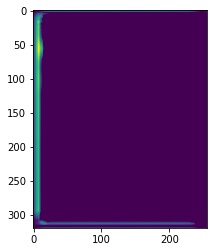

inf
inf
inf


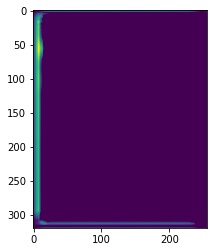

inf
inf
inf


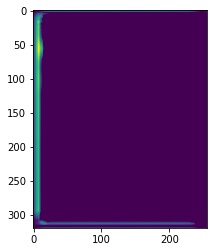

inf
inf
inf


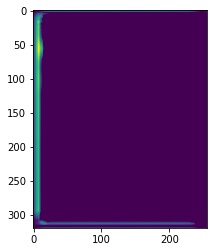

inf
inf
inf


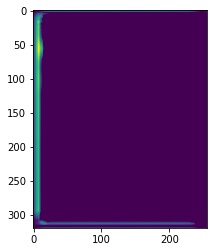

inf
inf
inf


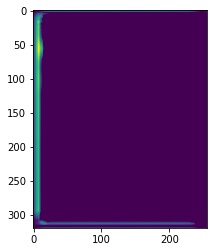

inf
inf
inf


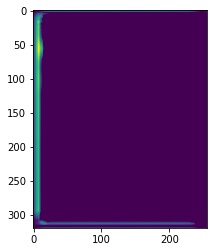

inf
inf
inf


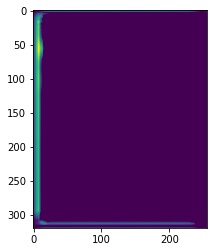

inf
inf
inf


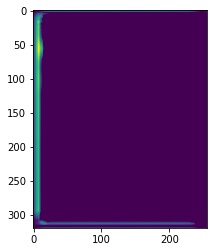

inf
inf
inf


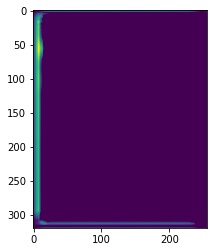

inf
inf
inf


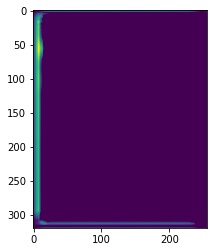

inf
inf
inf


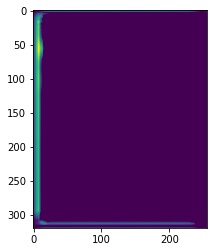

inf
inf
inf


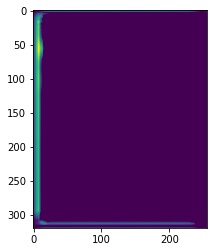

inf
inf
inf


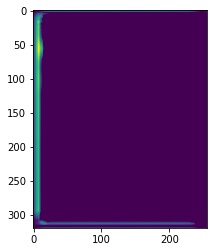

inf
inf
inf


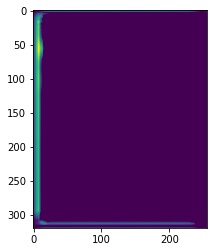

inf
inf
inf


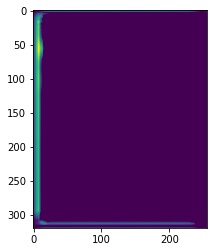

inf
inf
inf


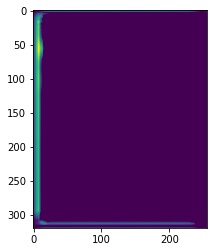

inf
inf
inf


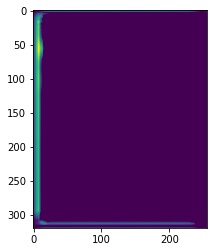

inf
inf
inf


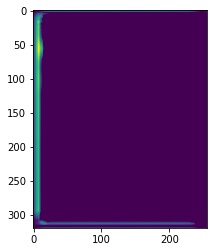

inf
inf
inf


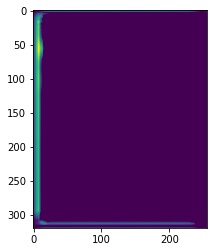

inf
inf
inf


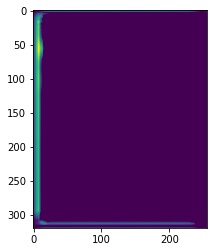

inf
inf
inf


KeyboardInterrupt: ignored

In [155]:
# model = Autoencoder()
# model.cuda()
# model.load_state_dict(torch.load("best.pth"))
model.eval()
maxs = 0
for i in range(250):
  data = transform_fn(dataT[i])
  data = torch.FloatTensor(data)
  if args.cuda:
          data = data.cuda()
  data = Variable(data)
  output = model(data) 
  img = output.cpu()
  img = img.detach().numpy()
  img = np.reshape(img,(320,256))
  s = SNR(img)
  plt.imshow(img)
  print(s)
  if(s>maxs and s<100000):
    maxs = s
    img2 = img
  plt.imshow(img2)
  plt.show()
print(maxs)

In [0]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [0]:
def SNR(dataT):
  variance = []
  defected_sum = []
  non_defected_sum = []
  values = []
  d_sum = 0
  non_sum = 0
  d1 = [50,72,51,69]
  d2 = [26,48,75,93]
  for p in range(0,2):
    for j in range(d1[p*2],d1[p*2+1]):
        for k in range(d2[p*2],d2[p*2]+1):
          d = dataT
          d_sum = d_sum + d[j][k]
    defected_sum.append(d_sum)
    for j in range(d1[p*2]):
        for k in range(d1[p*2+1]):
          d = dataT
          values.append(d[j][k])
          non_sum = non_sum + d[j][k]
    non_defected_sum.append(non_sum)
    variance.append(var(values))
    signal = (list(set(defected_sum) - set(non_defected_sum)))
    noise = sqrt(variance)
    SNR = signal/(noise*484)
    if(len(SNR)==0):
      return 0
    else:
      return max(SNR)